**CS7641 Assignment 1 - Supervised Learning - Robert Kiesler (rkiesler3)**

Wolberg,WIlliam. (1992). Breast Cancer Wisconsin (Original). UCI Machine Learning Repository. https://doi.org/10.24432/C5HP4Z.

https://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original

#Initial Library Imports and Labeling

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import time

In [ ]:
cols = ["SampleCodeNumber", "ClumpThinkness", "UniformityOfCellType", "UniformityOfCellShape", "MarginalAdhesion", "SingleEpithelialCellSize", "BareNuclei", "BlandChromatin", "NormalNucleoli", "Mitoses", "class"]
df = pd.read_csv("breast-cancer-wisconsin.data", names=cols)
df = df.drop(columns=["SampleCodeNumber"])

df.head(n=10)

In [ ]:
df["class"] = (df["class"] == 4).astype(int)
df.head(n=10)

In [ ]:
df.dtypes

In [ ]:
df.shape

(699, 10)

In [ ]:
#This column will print unique values of each column, point is to check for any weird values like "?"
for i in df.columns:
    print("*************************************************",i,"************************************************************")
    print()
    print(set(df[i].tolist()))
    print()

In [ ]:
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_imputed=pd.DataFrame(imp_mode.fit_transform(df))
df_imputed.columns=df.columns
df_imputed

In [ ]:
for i in df_imputed.columns:
    print("*************************************************",i,"************************************************************")
    print()
    print(set(df_imputed[i].tolist()))
    print()

In [ ]:
print(df_imputed["BareNuclei"].mode())

In [9]:
df_imputed["BareNuclei"]=df_imputed["BareNuclei"].apply(lambda x:'1' if x=='?'  else x)

In [ ]:
for i in df_imputed.columns:
    print("*************************************************",i,"************************************************************")
    print()
    print(set(df_imputed[i].tolist()))
    print()

In [ ]:
df_imputed.dtypes

In [12]:
for i in df.select_dtypes(exclude=["object"]).columns:
  df_imputed[i]=df_imputed[i].apply(lambda x: float(x))

In [ ]:
df_imputed.dtypes

#Train, Validation and Test datasets. Re-balancing included.


In [27]:
train, valid, test = np.split(df_imputed.sample(frac=1), [int(0.6*len(df_imputed)), int(0.8*len(df_imputed))]) #First split at 60% for training data, then second split 60-80% for validation, and 80%-100% will be for test data

In [28]:
def scale_dataset(dataframe, oversample=False):
  X = dataframe[dataframe.columns[:-1]].values #Setting independent variables
  y = dataframe[dataframe.columns[-1]].values #Setting dependent variable

  scaler = StandardScaler() #Creating scaler from sklearn because some of X values don't scale well (e.g. 300 vs 0.3)
  X = scaler.fit_transform(X)

  if oversample:
    ros = RandomOverSampler()
    X, y = ros.fit_resample(X, y)

  data = np.hstack((X, np.reshape(y, (-1, 1)))) #Stacking columns side by side

  return data, X, y


In [29]:
print(len(train[train["class"]==1]))
print(len(train[train["class"]==0]))

141
278


In [30]:
train, X_train, y_train = scale_dataset(train, oversample=True) #re-balancing the data
valid, X_valid, y_valid = scale_dataset(valid, oversample=False) #re-balancing the data, turning oversample off to question whether we can trust our model or not
test, X_test, y_test = scale_dataset(test, oversample=False) #re-balancing the data, turning oversample off to question whether we can trust our model or not

In [18]:
len(y_train)

548

In [19]:
len(X_train)

548

In [20]:
sum(y_train == 1) #confirmation of re-balancing

274

In [21]:
sum(y_train == 0) #confirmation of re-balancing

274

#Decision Tree w/ Pruning Implementation


In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

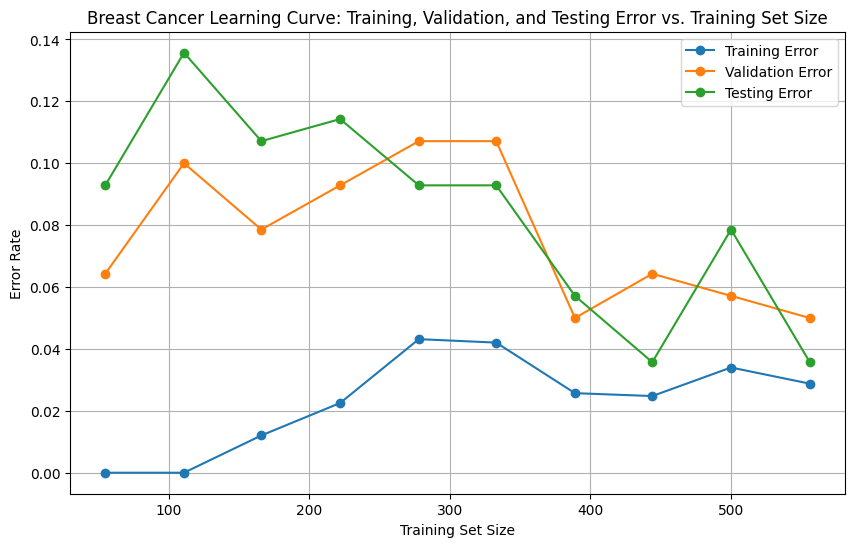

Training time for 55 samples: 0.014542 seconds
Training time for 111 samples: 0.012349 seconds
Training time for 166 samples: 0.008212 seconds
Training time for 222 samples: 0.014103 seconds
Training time for 278 samples: 0.002218 seconds
Training time for 333 samples: 0.018676 seconds
Training time for 389 samples: 0.005731 seconds
Training time for 444 samples: 0.002219 seconds
Training time for 500 samples: 0.010647 seconds
Training time for 556 samples: 0.023598 seconds


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import time
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

X_train, y_train = train[:, :-1], train[:, -1]
X_valid, y_valid = valid[:, :-1], valid[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

train_error_rates = []
validation_error_rates = []
test_error_rates = []
training_sizes = []
training_times = []

training_set_sizes = np.arange(0.1, 1.1, 0.1)  # 10% to 100% of the training data

# hyperparameters
max_depth_value = 5
min_samples_split_value = 5
min_samples_leaf_value = 2
prune_value = 0.01

for training_size in training_set_sizes:
    num_samples = int(training_size * len(X_train))
    X_subset = X_train[:num_samples]
    y_subset = y_train[:num_samples]

    start_time = time.time()

    dt_model = DecisionTreeClassifier(random_state=14, max_depth=max_depth_value,
                                       min_samples_split=min_samples_split_value,
                                       min_samples_leaf=min_samples_leaf_value,
                                       ccp_alpha=prune_value)
    dt_model.fit(X_subset, y_subset)

    end_time = time.time()

    train_error = 1 - dt_model.score(X_subset, y_subset)
    validation_error = 1 - dt_model.score(X_valid, y_valid)
    test_error = 1 - dt_model.score(X_test, y_test)

    train_error_rates.append(train_error)
    validation_error_rates.append(validation_error)
    test_error_rates.append(test_error)
    training_sizes.append(num_samples)

    training_time = end_time - start_time
    training_times.append(training_time)

plt.figure(figsize=(10, 6))
plt.plot(training_sizes, train_error_rates, marker='o', label='Training Error')
plt.plot(training_sizes, validation_error_rates, marker='o', label='Validation Error')
plt.plot(training_sizes, test_error_rates, marker='o', label='Testing Error')
plt.title('Breast Cancer Learning Curve: Training, Validation, and Testing Error vs. Training Set Size')
plt.xlabel('Training Set Size')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()


for size, time in zip(training_sizes, training_times):
    print(f"Training time for {size} samples: {time:.6f} seconds")


In [97]:
dt_model= DecisionTreeClassifier(random_state=14, max_depth=5, min_samples_split=5, min_samples_leaf=2)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=5,
                       random_state=14)

In [98]:
y_pred = dt_model.predict(X_test)

In [99]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.97        90
         1.0       0.89      1.00      0.94        50

    accuracy                           0.96       140
   macro avg       0.95      0.97      0.95       140
weighted avg       0.96      0.96      0.96       140



#kNN Implementation

In [55]:
from sklearn.neighbors import KNeighborsClassifier

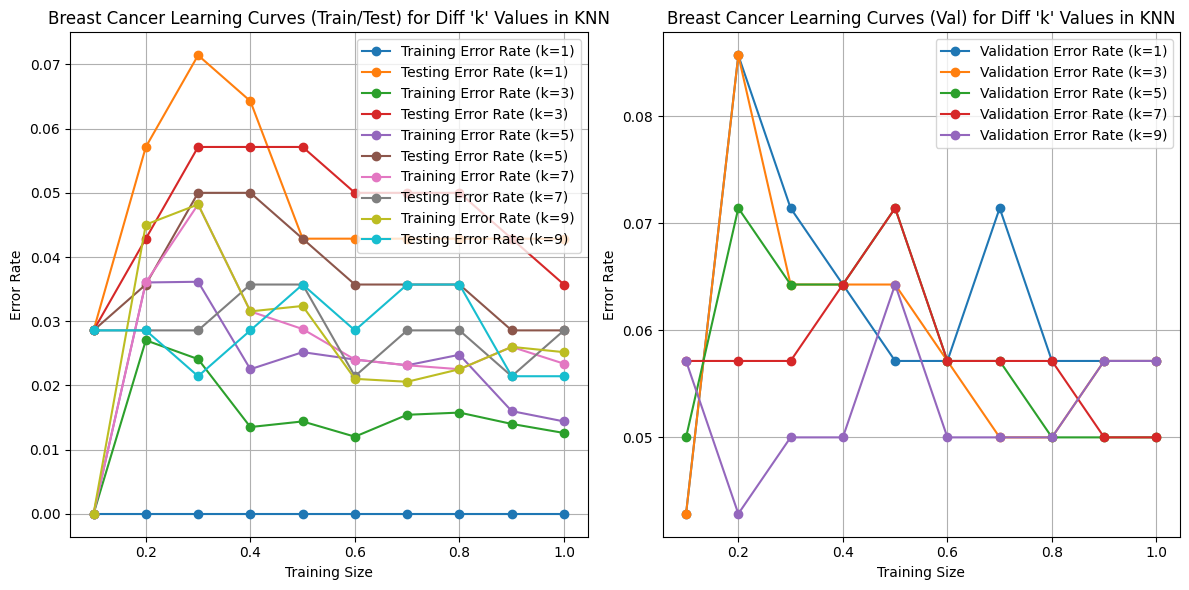

Training time for 0.1 samples (k=1): 0.058746 seconds
Training time for 0.2 samples (k=1): 0.047477 seconds
Training time for 0.30000000000000004 samples (k=1): 0.050898 seconds
Training time for 0.4 samples (k=1): 0.057599 seconds
Training time for 0.5 samples (k=1): 0.058083 seconds
Training time for 0.6 samples (k=1): 0.066723 seconds
Training time for 0.7000000000000001 samples (k=1): 0.089374 seconds
Training time for 0.8 samples (k=1): 0.075644 seconds
Training time for 0.9 samples (k=1): 0.080645 seconds
Training time for 1.0 samples (k=1): 0.108181 seconds
Training time for 0.1 samples (k=3): 0.039186 seconds
Training time for 0.2 samples (k=3): 0.044897 seconds
Training time for 0.30000000000000004 samples (k=3): 0.052416 seconds
Training time for 0.4 samples (k=3): 0.055795 seconds
Training time for 0.5 samples (k=3): 0.061079 seconds
Training time for 0.6 samples (k=3): 0.064849 seconds
Training time for 0.7000000000000001 samples (k=3): 0.095824 seconds
Training time for 0.

In [72]:
X_train, y_train = train[:, :-1], train[:, -1]
X_valid, y_valid = valid[:, :-1], valid[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

train_sizes = np.linspace(0.1, 1.0, 10)
k_values = [1, 3, 5, 7, 9]

train_error_rates = {k: [] for k in k_values}
validation_error_rates = {k: [] for k in k_values}
test_error_rates = {k: [] for k in k_values}
training_times = {k: [] for k in k_values}

for train_size in train_sizes:
    num_samples = int(train_size * len(X_train))
    X_subset = X_train[:num_samples]
    y_subset = y_train[:num_samples]

    for k in k_values:
        start_time = time.time()

        knn_model = KNeighborsClassifier(n_neighbors=k)
        knn_model.fit(X_subset, y_subset)

        train_accuracy = accuracy_score(y_subset, knn_model.predict(X_subset))
        validation_accuracy = accuracy_score(y_valid, knn_model.predict(X_valid))
        test_accuracy = accuracy_score(y_test, knn_model.predict(X_test))

        train_error = 1 - train_accuracy
        validation_error = 1 - validation_accuracy
        test_error = 1 - test_accuracy

        train_error_rates[k].append(train_error)
        validation_error_rates[k].append(validation_error)
        test_error_rates[k].append(test_error)

        end_time = time.time()
        training_time = end_time - start_time
        training_times[k].append(training_time)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for k in k_values:
    plt.plot(train_sizes, train_error_rates[k], 'o-', label=f"Training Error Rate (k={k})")
    plt.plot(train_sizes, test_error_rates[k], 'o-', label=f"Testing Error Rate (k={k})")

plt.title("Breast Cancer Learning Curves (Train/Test) for Diff 'k' Values in KNN")
plt.xlabel("Training Size")
plt.ylabel("Error Rate")
plt.legend(loc="best")
plt.grid(True)

plt.subplot(1, 2, 2)
for k in k_values:
    plt.plot(train_sizes, validation_error_rates[k], 'o-', label=f"Validation Error Rate (k={k})")

plt.title("Breast Cancer Learning Curves (Val) for Diff 'k' Values in KNN")
plt.xlabel("Training Size")
plt.ylabel("Error Rate")
plt.legend(loc="best")
plt.grid(True)

plt.tight_layout()
plt.show()


for k in k_values:
    for size, time_ in zip(train_sizes, training_times[k]):
        print(f"Training time for {size} samples (k={k}): {time_:.6f} seconds")

In [73]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train) #using the training data

KNeighborsClassifier()

In [77]:
y_pred = knn_model.predict(X_test) #create predict based on test set

In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98        90
         1.0       0.94      0.98      0.96        50

    accuracy                           0.97       140
   macro avg       0.97      0.97      0.97       140
weighted avg       0.97      0.97      0.97       140



#SVM Implementation

In [57]:
from sklearn.svm import SVC

In [58]:
kernel_functions = ['linear', 'poly', 'rbf', 'sigmoid']

Kernel: linear
Kernel: poly
Kernel: rbf
Kernel: sigmoid


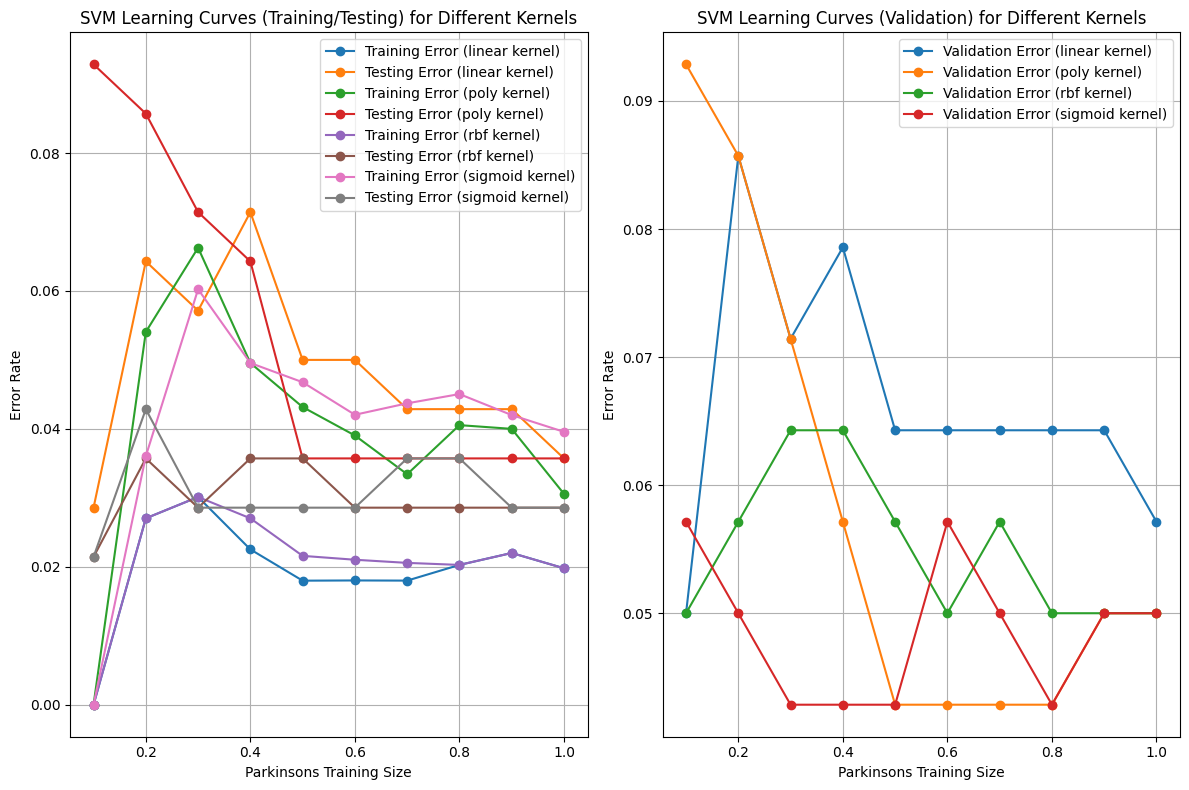

Training time for linear kernel, 10.0% of data: 0.002711 seconds
Training time for linear kernel, 20.0% of data: 0.001724 seconds
Training time for linear kernel, 30.0% of data: 0.002166 seconds
Training time for linear kernel, 40.0% of data: 0.009625 seconds
Training time for linear kernel, 50.0% of data: 0.003040 seconds
Training time for linear kernel, 60.0% of data: 0.003140 seconds
Training time for linear kernel, 70.0% of data: 0.003064 seconds
Training time for linear kernel, 80.0% of data: 0.004357 seconds
Training time for linear kernel, 90.0% of data: 0.005332 seconds
Training time for linear kernel, 100.0% of data: 0.006256 seconds
Training time for poly kernel, 10.0% of data: 0.007096 seconds
Training time for poly kernel, 20.0% of data: 0.001598 seconds
Training time for poly kernel, 30.0% of data: 0.002017 seconds
Training time for poly kernel, 40.0% of data: 0.002234 seconds
Training time for poly kernel, 50.0% of data: 0.004065 seconds
Training time for poly kernel, 60.

In [62]:
train_sizes = np.linspace(0.1, 1.0, 10)

train_error_rates = {kernel: [] for kernel in kernel_functions}
valid_error_rates = {kernel: [] for kernel in kernel_functions}
test_error_rates = {kernel: [] for kernel in kernel_functions}
training_times = {kernel: [] for kernel in kernel_functions}

for kernel in kernel_functions:
    print(f"Kernel: {kernel}")

    for train_size in train_sizes:
        num_samples = int(train_size * len(X_train))
        X_subset = X_train[:num_samples]
        y_subset = y_train[:num_samples]

        svm_model = SVC(kernel=kernel)

        start_time = time.time()
        svm_model.fit(X_subset, y_subset)
        end_time = time.time()
        training_time = end_time - start_time

        train_accuracy = svm_model.score(X_subset, y_subset)
        valid_accuracy = svm_model.score(X_valid, y_valid)
        test_accuracy = svm_model.score(X_test, y_test)

        train_error = 1 - train_accuracy
        valid_error = 1 - valid_accuracy
        test_error = 1 - test_accuracy

        train_error_rates[kernel].append(train_error)
        valid_error_rates[kernel].append(valid_error)
        test_error_rates[kernel].append(test_error)
        training_times[kernel].append(training_time)


plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
for kernel in kernel_functions:
    plt.plot(train_sizes, train_error_rates[kernel], marker='o', label=f"Training Error ({kernel} kernel)")
    plt.plot(train_sizes, test_error_rates[kernel], marker='o', label=f"Testing Error ({kernel} kernel)")

plt.title("SVM Learning Curves (Training/Testing) for Different Kernels")
plt.xlabel("Parkinsons Training Size")
plt.ylabel("Error Rate")
plt.legend(loc="best")
plt.grid(True)

plt.subplot(1, 2, 2)
for kernel in kernel_functions:
    plt.plot(train_sizes, valid_error_rates[kernel], marker='o', label=f"Validation Error ({kernel} kernel)")

plt.title("SVM Learning Curves (Validation) for Different Kernels")
plt.xlabel("Parkinsons Training Size")
plt.ylabel("Error Rate")
plt.legend(loc="best")
plt.grid(True)

plt.tight_layout()
plt.show()

for kernel in kernel_functions:
    for size, time_ in zip(train_sizes, training_times[kernel]):
        print(f"Training time for {kernel} kernel, {size:.1%} of data: {time_:.6f} seconds")

Kernel: linear
Kernel: poly
Kernel: rbf
Kernel: sigmoid


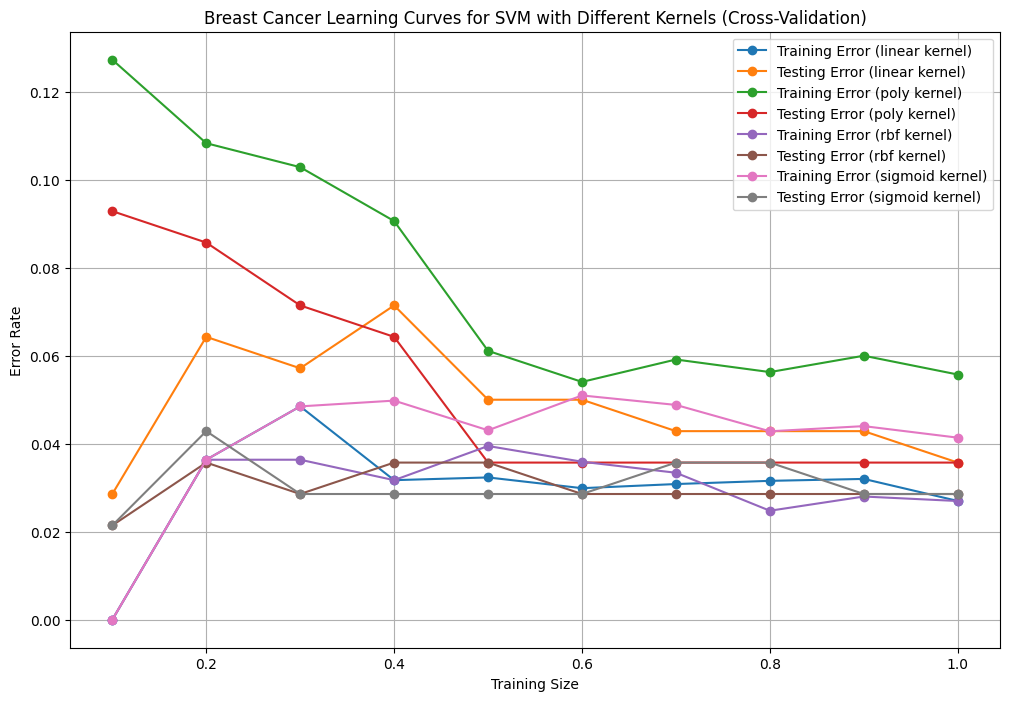

In [105]:
### SAME SECTION AS ABOVE BUT HERE I AM IMPLEMENTING CROSS VALIDATION ###
from sklearn.model_selection import cross_val_score

train_sizes = np.linspace(0.1, 1.0, 10)

train_error_rates = {kernel: [] for kernel in kernel_functions}
test_error_rates = {kernel: [] for kernel in kernel_functions}

for kernel in kernel_functions:
    print(f"Kernel: {kernel}")

    for train_size in train_sizes:
        num_samples = int(train_size * len(X_train))
        X_subset = X_train[:num_samples]
        y_subset = y_train[:num_samples]

        svm_model = SVC(kernel=kernel)
        scores = cross_val_score(svm_model, X_subset, y_subset, cv=5)  # 5 folds due to limited dataset instead of 10

        train_error = 1 - np.mean(scores)
        test_error = 1 - svm_model.fit(X_subset, y_subset).score(X_test, y_test)

        train_error_rates[kernel].append(train_error)
        test_error_rates[kernel].append(test_error)

plt.figure(figsize=(12, 8))

for kernel in kernel_functions:
    plt.plot(train_sizes, train_error_rates[kernel], marker='o', label=f"Training Error ({kernel} kernel)")
    plt.plot(train_sizes, test_error_rates[kernel], marker='o', label=f"Testing Error ({kernel} kernel)")

plt.title("Breast Cancer Learning Curves for SVM with Different Kernels (Cross-Validation)")
plt.xlabel("Training Size")
plt.ylabel("Error Rate")
plt.legend(loc="best")
plt.grid(True)
plt.show()


In [104]:
for kernel in kernel_functions:
    print(f"Kernel: {kernel}")

    svm_model = SVC(kernel=kernel, degree=3) #creatin a SVM model with the specified kernel function

    svm_model.fit(X_train, y_train)

    y_pred = svm_model.predict(X_test)

    # classification report
    print(classification_report(y_test, y_pred))
    print("=" * 40)

Kernel: linear
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97        90
         1.0       0.96      0.94      0.95        50

    accuracy                           0.96       140
   macro avg       0.96      0.96      0.96       140
weighted avg       0.96      0.96      0.96       140

Kernel: poly
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97        90
         1.0       0.98      0.92      0.95        50

    accuracy                           0.96       140
   macro avg       0.97      0.95      0.96       140
weighted avg       0.96      0.96      0.96       140

Kernel: rbf
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98        90
         1.0       0.94      0.98      0.96        50

    accuracy                           0.97       140
   macro avg       0.97      0.97      0.97       140
weighted avg       0.97      0.97 

#Neural Net Implementation

In [63]:
import tensorflow as tf

In [64]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.title('Breast Cancer Loss Curve')
  plt.xlabel('Epoch')
  plt.ylabel('Binary Crossentropy')
  plt.legend()
  plt.grid(True)
  plt.show()

def plot_accuracy(history):
  plt.plot(history.history['accuracy'], label='Accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.title('Breast Cancer Accuracy Curve')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()


In [69]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(9, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])



In [70]:
history = nn_model.fit(
    X_train,
    y_train,
    epochs = 100,
    batch_size = 16,
    validation_split = 0.2,
    verbose = False
)

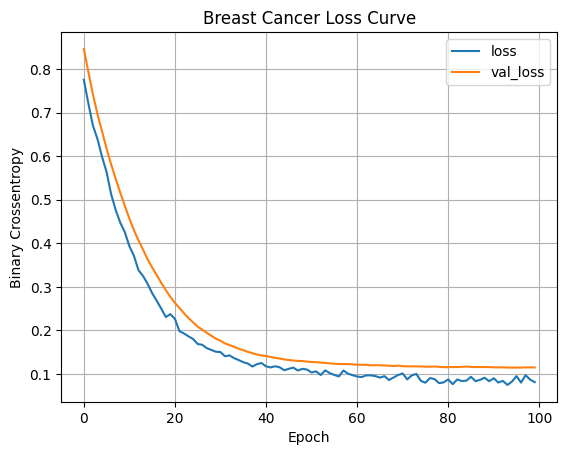

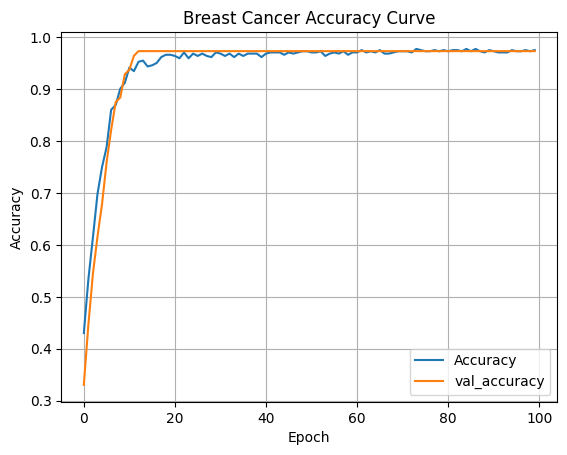

In [71]:
plot_loss(history)
plot_accuracy(history)

In [ ]:
y_pred = nn_model.predict(X_test)
y_pred = np.round(y_pred)  # Convert probabilities to binary predictions

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


5/5 [==============================] - 0s 3ms/step
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97        91
         1.0       0.94      0.94      0.94        49

    accuracy                           0.96       140
   macro avg       0.95      0.95      0.95       140
weighted avg       0.96      0.96      0.96       140



#Boosting Implementation

In [44]:
from xgboost import XGBClassifier

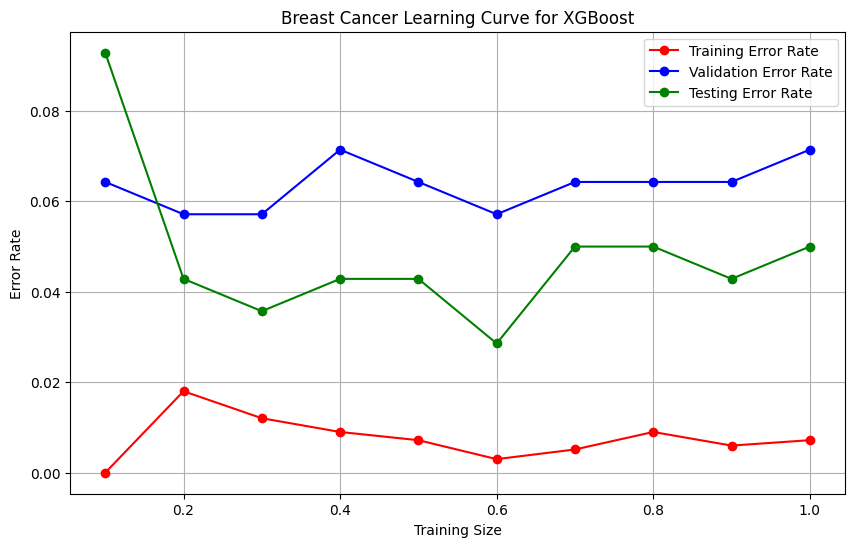

Training time for 0.1 samples: 0.020630 seconds
Training time for 0.2 samples: 0.072151 seconds
Training time for 0.30000000000000004 samples: 0.058954 seconds
Training time for 0.4 samples: 0.096413 seconds
Training time for 0.5 samples: 0.134317 seconds
Training time for 0.6 samples: 0.199701 seconds
Training time for 0.7000000000000001 samples: 0.148564 seconds
Training time for 0.8 samples: 0.138309 seconds
Training time for 0.9 samples: 0.197322 seconds
Training time for 1.0 samples: 0.083103 seconds


In [84]:
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import time

X_train, y_train = train[:, :-1], train[:, -1]
X_valid, y_valid = valid[:, :-1], valid[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

train_sizes = np.linspace(0.1, 1.0, 10)

train_error_rates = []
validation_error_rates = []
test_error_rates = []
training_times = []

# Hyperparameters
max_depth_value = 3
min_child_weight_value = 2

for train_size in train_sizes:
    num_samples = int(train_size * len(X_train))
    X_subset = X_train[:num_samples]
    y_subset = y_train[:num_samples]

    start_time = time.time()

    xgb_model = XGBClassifier(
        max_depth=max_depth_value,
        min_child_weight=min_child_weight_value,
        random_state=42
    )
    xgb_model.fit(X_subset, y_subset)
    train_accuracy = accuracy_score(y_subset, xgb_model.predict(X_subset))
    validation_accuracy = accuracy_score(y_valid, xgb_model.predict(X_valid))
    test_accuracy = accuracy_score(y_test, xgb_model.predict(X_test))

    train_error = 1 - train_accuracy
    validation_error = 1 - validation_accuracy
    test_error = 1 - test_accuracy

    train_error_rates.append(train_error)
    validation_error_rates.append(validation_error)
    test_error_rates.append(test_error)

    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_error_rates, 'o-', color="r", label="Training Error Rate")
plt.plot(train_sizes, validation_error_rates, 'o-', color="b", label="Validation Error Rate")
plt.plot(train_sizes, test_error_rates, 'o-', color="g", label="Testing Error Rate")
plt.title("Breast Cancer Learning Curve for XGBoost")
plt.xlabel("Training Size")
plt.ylabel("Error Rate")
plt.legend(loc="best")
plt.grid(True)
plt.show()

for size, time in zip(train_sizes, training_times):
    print(f"Training time for {size} samples: {time:.6f} seconds")


In [79]:
# Get the number of trees (boosting rounds)
num_trees = xgb_model.n_estimators

# Print the number of trees
print(f"Number of Trees (Boosting Rounds): {num_trees}")

Number of Trees (Boosting Rounds): 100


In [80]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [81]:
y_pred = xgb_model.predict(X_test) #create predict based on test set

In [82]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95        90
         1.0       0.94      0.88      0.91        50

    accuracy                           0.94       140
   macro avg       0.94      0.92      0.93       140
weighted avg       0.94      0.94      0.94       140

